## Challenge

1. Show the number of lines said per character throughout the play.

2. Make a word cloud of unusual words in the script

3. Compute the sentiment score for each scene.


In [26]:
import re
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
from wordcloud import WordCloud

import matplotlib as mp

from collections import defaultdict

%matplotlib inline
mp.rcParams['figure.figsize'] = (16, 10)
mp.pyplot.style.use('ggplot')


##  Number of lines said per character

In [2]:
# Read and parse play
#
# - skip first irrelevant lines
# - remove empty lines
# - partition text by scene
#

N_SKIP = 80
lines = []
all_scenes = {}

with open('hamlet.txt', 'r') as f:
    cnt = defaultdict(int)
    for num, line in enumerate(f.readlines()):
        if num < N_SKIP:
            # Just remove first few lines to avoid parsing of unnecessary lines
            cnt['skip'] += 1
            continue # Skip firs lines
            
        if line.strip() == '':
            cnt['empty'] += 1
            continue

        r = re.match('\ASCENE\s(.+?)\s', line)
        if r:
            cnt['scene'] += 1
            if len(lines) > 0:
                key = 'ACT ' + act + ' SCENE ' + scene
                print(key)
                all_scenes[key] = lines
            lines = []
            scene = r.group(1)
            continue

        r = re.match('\AACT\s(.+?)\s', line)
        if r:
            cnt['act'] += 1
            if len(lines) > 0:
                key = 'ACT ' + act + ' SCENE ' + scene
                print(key)
                all_scenes[key] = lines
            lines = []
            act = r.group(1)
            continue

                        
        if re.match('\tHAMLET', line):
            cnt['caption'] += 1
            continue
        
        cnt['rest'] += 1
        lines.append(line)

    all_scenes['ACT ' + act + ' SCENE ' + scene] = lines
# 
num + 1, sum([v for k, v in cnt.items()])

ACT I SCENE I
ACT I SCENE II
ACT I SCENE III
ACT I SCENE IV
ACT I SCENE V
ACT II SCENE I
ACT II SCENE II
ACT III SCENE I
ACT III SCENE II
ACT III SCENE III
ACT III SCENE IV
ACT IV SCENE I
ACT IV SCENE II
ACT IV SCENE III
ACT IV SCENE IV
ACT IV SCENE V
ACT IV SCENE VI
ACT IV SCENE VII


(5054, 5054)

In [3]:
#
# - remove comments [...]
# - fix double lines (when two characters tell one line)
# - partition line by character
#
# Ouptuts a list of tuples (character, line)

def process_scene(lines):
    text = ''.join(lines)

    # Remove all comments like this: [...]
    text = re.sub(r'\[.+?\]', '', text, count=0, flags=re.MULTILINE | re.DOTALL)

    # There are few places like this:
    # 
    # ROSENCRANTZ:	|
    # 	|   [Within]  Hamlet! Lord Hamlet!
    # GUILDENSTERN:	|

    #re.findall('(.+?)\:?\t\|\n\t\|\t?(.+)\n(.+?)\:?\t\|', text)
    text = re.sub(r'(.+?)\:?\t\|\n\t\|\t?(.+)\n(.+?)\:?\t\|', r'\1\t\2\n\3\t\2', text)

    # Back to lines
    lines = [line.strip() for line in text.split('\n') if line.strip() != '']
    
    res_lines = []
    who = None
    for line in lines:
        r = re.match('^(.+)\t(.+)', line)
        if r:
            if who:
                res_lines.append((who, res_line))
            who = r.group(1)
            res_line = r.group(2)
        else:
            res_line += ' ' + line
            
    # Finally add the last line
    res_lines.append((who, res_line))
    
    return res_lines

In [4]:
#
# Process all scenes in all acts
# 

processed_scenes = { scene: process_scene(lines) for scene, lines in all_scenes.items()}

In [5]:
d = [(scene, line[0].strip(), line[1].strip()) for scene, lines in processed_scenes.items() for line in lines]
df = pd.DataFrame(d, columns=['scene', 'who', 'line'])

In [6]:
#
# Lines by character in alphabetical order
# 

df.groupby('who')['line'].count()

who
All                    2
BERNARDO              23
CORNELIUS              1
Captain                7
Danes                  3
FRANCISCO              8
First Clown           13
First Player           8
First Sailor           2
GUILDENSTERN          33
Gentleman              3
Ghost                 14
HAMLET               265
HORATIO               79
KING CLAUDIUS         87
LAERTES               41
LORD POLONIUS         85
LUCIANUS               1
MARCELLUS             36
Messenger              2
OPHELIA               53
PRINCE FORTINBRAS      2
Player King            4
Player Queen           5
Prologue               1
QUEEN GERTRUDE        60
REYNALDO              13
ROSENCRANTZ           49
Second Clown          12
Servant                1
VOLTIMAND              2
Name: line, dtype: int64

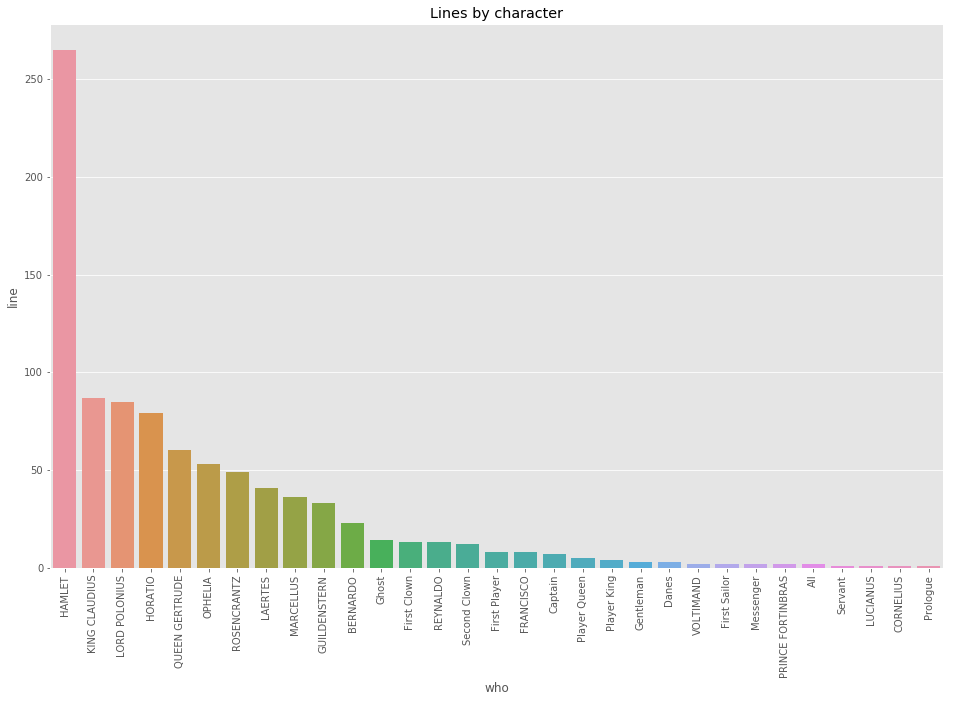

In [10]:
#
# Lines by character, "who talk more"
#

s = df.groupby('who')['line'].count().sort_values(ascending=False)
sns.barplot(s.index, s)
_ = plt.xticks(rotation=90)
_ = plt.title('Lines by character')

# Wordcloud

In [11]:
import nltk
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/alexey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/alexey/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alexey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/alexey/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from nltk import FreqDist, pos_tag

from nltk.corpus import wordnet, stopwords, brown

from functools import reduce

In [13]:
lem = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Provides tags for lemmatizer"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def mk_counts(sents):
    """Make frequency distribution out of sentances"""
    tagged = [nltk.pos_tag(sent) for sent in sents]
    words_with_tags = reduce(list.__add__, tagged)
    words_lemmatized = [lem.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in words_with_tags]
    words = [word.lower() for word in words_lemmatized]
    return FreqDist(words)

In [14]:
#
# In order to find unusual words we need something to compare with
# something what's usual

hamlet_sentances = [word_tokenize(sent) for sent in sent_tokenize("\n".join(list(df['line'])))]
brown_sentances = brown.sents()

In [21]:
dist_hamlet = mk_counts(hamlet_sentances)

In [22]:
dist_brown = mk_counts(brown_sentances)

In [23]:
#
# JOIN datasets to compare word occurances in Hamlet vs. reference (brown) dataset

words_df1 = pd.DataFrame(dist_brown.items(), columns=['word', 'cnt_ref'])
words_df2 = pd.DataFrame(dist_hamlet.items(), columns=['word', 'cnt'])
mdf = pd.merge(words_df2, words_df1, on='word', how='left')

# N/A to zero occurances
mdf = mdf.fillna(0)

In [24]:
# remove single char words
# remove words with ', because they're often not normal words but result of tokenization
# remove stopwords
# remove character names as they're not really "unusial" or can be considered separately as named entities

sw = set(stopwords.words('english'))
cnames = df.who.str.lower().unique()

mdf = mdf[(mdf['word'].str.len() > 1) & 
          (mdf['word'].str.find("'") == -1) & 
          (~mdf['word'].isin(sw)) & 
          (~mdf['word'].isin(cnames))].copy()

In [27]:
total = words_df2['cnt'].sum()
total_ref = words_df1['cnt_ref'].sum() 

E1 = total * (mdf['cnt'] + mdf['cnt_ref']) / (total + total_ref)
E2 = total_ref * (mdf['cnt'] + mdf['cnt_ref']) / (total + total_ref)

# log-likelihood ratio statistic
mdf['G2'] = 2 * ((mdf['cnt'] * np.log(mdf['cnt'] / E1 + 1e-20)) + 
          (mdf['cnt_ref'] * np.log(mdf['cnt_ref'] / E2 + 1e-20)))

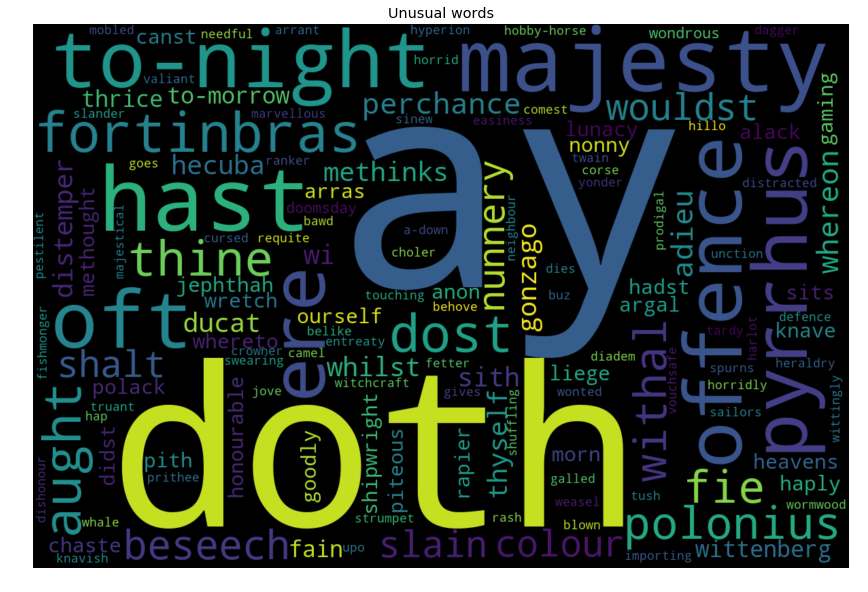

In [28]:
#
# G2 > 10.83 means p < 0.001
# So we limit our words by both counts in reference dataset and G2
# to get not very many words for wordcloud

res = mdf[(mdf['cnt_ref'] < 2) & (mdf['G2'] > 10.83)].sort_values('G2', ascending=False)

counts = res[['word', 'cnt']].copy()
total = counts['cnt'].sum()
counts['cnt'] = counts['cnt'] / total

freqs = counts.set_index('word').to_dict()['cnt']
wordcloud = WordCloud(width=1200, height=800).generate_from_frequencies(freqs)

plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.title("Unusual words")

In [29]:
#
# We can also consider words to be "unusual" if they occur noticeably more often or more seldom
# In this case we need words with high G2 statistics

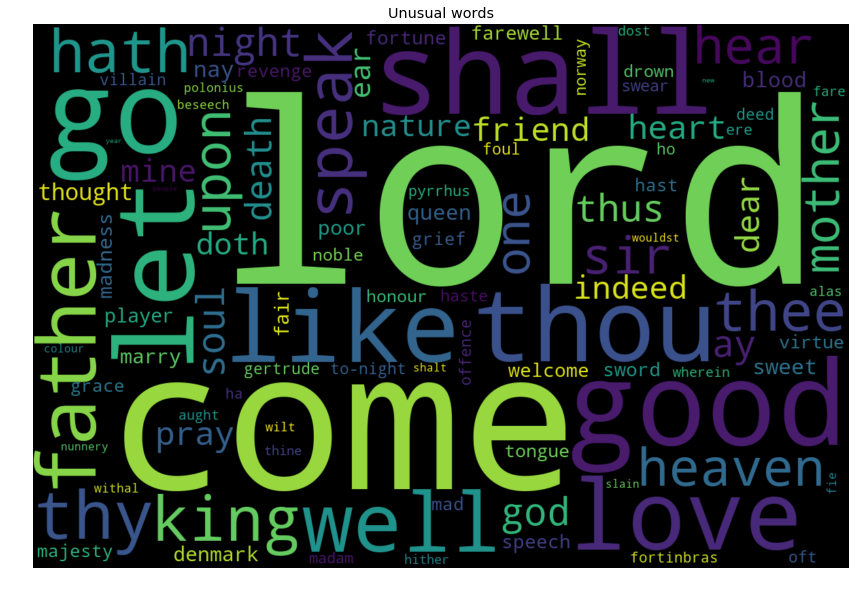

In [30]:
#
# We can also consider words to be "unusual" if they occur noticeably more often or more seldom
# In this case we need words with high G2 statistics
# But again without stop words and w/o character names

res = mdf.sort_values('G2', ascending=False)[0:100]

counts = res[['word', 'cnt']].copy()
total = counts['cnt'].sum()
counts['cnt'] = counts['cnt'] / total

freqs = counts.set_index('word').to_dict()['cnt']
wordcloud = WordCloud(width=1200, height=800).generate_from_frequencies(freqs)

plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.title("Unusual words")

## Sentiment

In [31]:
#
# Sentiment analysis is easier to do with some API, there are planty of them
# see for example this list 
# https://medium.com/@Mandysidana/top-five-emotional-sentiment-analysis-apis-116cd8d42055


# Imports the Google Cloud client library

from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

import os

sentiment = pd.DataFrame({'scene': df['scene'].unique()})

# The credentials file is not in the repository !!!
# Ask me to provide it or create yourself here: https://cloud.google.com/natural-language/docs/quickstart
# You will need a google cloud account
#

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.expanduser('./My-cred.json')

# Instantiates a client
client = language.LanguageServiceClient()

for idx, doc in df.groupby('scene')['line'].apply(lambda x: list(x)).iteritems():
    document = types.Document(
        content=' '.join(doc),
        type=enums.Document.Type.PLAIN_TEXT)

    # Detects the sentiment of the text
    sentiment_res = client.analyze_sentiment(document=document).document_sentiment
    sentiment.loc[sentiment.scene == idx, 'score'] = sentiment_res.score
    sentiment.loc[sentiment.scene == idx, 'magnitude'] = sentiment_res.magnitude

In [32]:
sentiment

,scene,score,magnitude
0,ACT I SCENE I,0.0,29.900000
1,ACT I SCENE II,0.1,49.000000
2,ACT I SCENE III,0.1,19.200001
3,ACT I SCENE IV,0.0,16.299999
4,ACT I SCENE V,0.0,44.900002
5,ACT II SCENE I,0.1,18.700001
6,ACT II SCENE II,0.1,100.199997
7,ACT III SCENE I,0.1,28.000000
8,ACT III SCENE II,0.0,71.900002
9,ACT III SCENE III,0.0,16.400000
